# This notebook has the commands for creating a horizontal bar chart for the ADHD proportion data within communities

In [153]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [154]:
filtered_data_arms1 = pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/list_ADHDscores_ARMS2_arms1xgb_merged.csv")
filtered_data_arms2= pd.read_csv("/home/faird/lundq163/projects/FRF_results_viz/GBM_work/list_ADHDscores_ARMS1_arms2xgb_merged.csv")
#data_arms2 = pd.read_csv("/home/feczk001/shared/projects/FEZ_USERS/feczk001/UPPS_ABCD_FRF/code/jacob/ADHDscores_list_ARMS2_merged.csv")
filtered_data_arms2

,subjectkey,ADHD1,ADHD2,ADHD3,ADHD4,ADHDcomposite,community
0,NDAR_INV003RTV85,Ctrl,Ctrl,Ctrl,Ctrl,-0.638587,2
1,NDAR_INV007W6H7B,Ctrl,Ctrl,Ctrl,Ctrl,-0.189392,2
2,NDAR_INV00BD7VDC,Ctrl,Ctrl,Ctrl,Ctrl,0.907719,0
3,NDAR_INV00HEV6HB,Ctrl,Ctrl,Ctrl,Ctrl,-0.254566,1
4,NDAR_INV00LH735Y,Ctrl,Ctrl,Ctrl,Ctrl,-0.526288,5
...,...,...,...,...,...,...,...
3141,NDAR_INVZY8L7CT1,Ctrl,Ctrl,Ctrl,Ctrl,-0.077094,4
3142,NDAR_INVZYC44GB8,Ctrl,Ctrl,Ctrl,Ctrl,0.251977,0
3143,NDAR_INVZZ05KY5J,Ctrl,Ctrl,Ctrl,Ctrl,0.017155,1
3144,NDAR_INVZZFG6J5U,Ctrl,Ctrl,Ctrl,Ctrl,0.002618,4


In [134]:
#currently keeping all communities, regardless of size, because we are trying to evaluate across the arms with the overfit xgb model

#communities_more_than_100_arms1 = data_arms1['community'].value_counts()[data_arms1['community'].value_counts() > 100].index
#communities_more_than_100_arms2 = data_arms2['community'].value_counts()[data_arms2['community'].value_counts() > 100].index

#filtered_data_arms1 = data_arms1[data_arms1['community'].isin(communities_more_than_100_arms1)]
#filtered_data_arms2 = data_arms2[data_arms2['community'].isin(communities_more_than_100_arms2)]

In [155]:
#cast community as a category

filtered_data_arms1['community'] = filtered_data_arms1['community'].astype('category')
filtered_data_arms2['community'] = filtered_data_arms2['community'].astype('category')

In [156]:
#function to determine the grouping of all possible adhd label combinations/conditions

def filter_adhd(df, **conditions):
    query = ' & '.join([f"{k} == '{v}'" for k, v in conditions.items()])
    return df.query(query)

In [157]:
#all the possible adhd label combinations/conditions

conditions_arms1 = [
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'Ctrl'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'Ctrl', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'Ctrl', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'Ctrl', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'},
    {'ADHD1': 'ADHD', 'ADHD2': 'ADHD', 'ADHD3': 'ADHD', 'ADHD4': 'ADHD'}
]

conditions_arms2 = conditions_arms1  # The conditions are the same for arms2

In [158]:
#determine the counts for the condition groups

groups_arms1 = [filtered_data_arms1] + [filter_adhd(filtered_data_arms1, **cond) for cond in conditions_arms1]
groups_arms2 = [filtered_data_arms2] + [filter_adhd(filtered_data_arms2, **cond) for cond in conditions_arms2]
groups_arms2

[            subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
 0     NDAR_INV003RTV85  Ctrl  Ctrl  Ctrl  Ctrl      -0.638587         2
 1     NDAR_INV007W6H7B  Ctrl  Ctrl  Ctrl  Ctrl      -0.189392         2
 2     NDAR_INV00BD7VDC  Ctrl  Ctrl  Ctrl  Ctrl       0.907719         0
 3     NDAR_INV00HEV6HB  Ctrl  Ctrl  Ctrl  Ctrl      -0.254566         1
 4     NDAR_INV00LH735Y  Ctrl  Ctrl  Ctrl  Ctrl      -0.526288         5
 ...                ...   ...   ...   ...   ...            ...       ...
 3141  NDAR_INVZY8L7CT1  Ctrl  Ctrl  Ctrl  Ctrl      -0.077094         4
 3142  NDAR_INVZYC44GB8  Ctrl  Ctrl  Ctrl  Ctrl       0.251977         0
 3143  NDAR_INVZZ05KY5J  Ctrl  Ctrl  Ctrl  Ctrl       0.017155         1
 3144  NDAR_INVZZFG6J5U  Ctrl  Ctrl  Ctrl  Ctrl       0.002618         4
 3145  NDAR_INVZZL0VA2F  Ctrl  Ctrl  Ctrl  Ctrl      -0.301691         1
 
 [3146 rows x 7 columns],
             subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
 0     NDAR_INV003RTV85

In [160]:
#better display of the counts

for group in groups_arms1:
    if not group.empty:
        print(group.head(1))
        print(len(group))

#outputs are in order: total, no adhd, adhd1, adhd2, adhd3, adhd4

         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
0  NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275         3
3176
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
0  NDAR_INV00J52GPG  Ctrl  Ctrl  Ctrl  Ctrl       0.364275         3
2928
           subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
158  NDAR_INV20CNYBBC  ADHD  Ctrl  Ctrl  Ctrl       1.741991         2
7
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
3  NDAR_INV021403LF  ADHD  ADHD  Ctrl  Ctrl       1.444422         7
90
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
48  NDAR_INV0JAG7BGC  ADHD  ADHD  ADHD  Ctrl       1.936428         3
55
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
72  NDAR_INV0UMM15GY  ADHD  ADHD  ADHD  ADHD       3.435609         0
96


In [161]:
for group in groups_arms2:
    if not group.empty:
        print(group.head(1))
        print(len(group))

         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
0  NDAR_INV003RTV85  Ctrl  Ctrl  Ctrl  Ctrl      -0.638587         2
3146
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
0  NDAR_INV003RTV85  Ctrl  Ctrl  Ctrl  Ctrl      -0.638587         2
2931
           subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
316  NDAR_INV2DTHE81G  ADHD  Ctrl  Ctrl  Ctrl        2.79549         5
14
          subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
23  NDAR_INV05LGG3GZ  ADHD  ADHD  Ctrl  Ctrl       1.067142         0
83
           subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
103  NDAR_INV0UPRUMA1  ADHD  ADHD  ADHD  Ctrl       0.098208         1
42
         subjectkey ADHD1 ADHD2 ADHD3 ADHD4  ADHDcomposite community
6  NDAR_INV00U4FTRU  ADHD  ADHD  ADHD  ADHD       2.920183         1
76


In [162]:
#functions to summarize the label counts into one dataframe

def summarize_by_label(df, label):
    summary = df.groupby(['community', label], observed=False).size().reset_index(name='count')
    return summary[summary[label] == 'ADHD'].assign(ADHD=label)

def summarize_by_label_ctrl(df, label):
    summary = df.groupby(['community', label], observed=False).size().reset_index(name='count')
    return summary[summary[label] == 'Ctrl'].assign(ADHD='Ctrl')

In [163]:
summary_data_arms1_ctrl_adhd1 = summarize_by_label_ctrl(filtered_data_arms1, 'ADHD1')
summary_data_arms1_ADHD1 = summarize_by_label(filtered_data_arms1, 'ADHD1')
summary_data_arms1_ADHD2 = summarize_by_label(filtered_data_arms1, 'ADHD2')
summary_data_arms1_ADHD3 = summarize_by_label(filtered_data_arms1, 'ADHD3')
summary_data_arms1_ADHD4 = summarize_by_label(filtered_data_arms1, 'ADHD4')

In [164]:
summary_data_arms2_ctrl_adhd1 = summarize_by_label_ctrl(filtered_data_arms2, 'ADHD1')
summary_data_arms2_ADHD1 = summarize_by_label(filtered_data_arms2, 'ADHD1')
summary_data_arms2_ADHD2 = summarize_by_label(filtered_data_arms2, 'ADHD2')
summary_data_arms2_ADHD3 = summarize_by_label(filtered_data_arms2, 'ADHD3')
summary_data_arms2_ADHD4 = summarize_by_label(filtered_data_arms2, 'ADHD4')

In [165]:
#combine the summaries together

summary_data_arms1_combined = pd.concat([summary_data_arms1_ctrl_adhd1, summary_data_arms1_ADHD1, summary_data_arms1_ADHD2, summary_data_arms1_ADHD3, summary_data_arms1_ADHD4])
summary_data_arms2_combined = pd.concat([summary_data_arms2_ctrl_adhd1, summary_data_arms2_ADHD1, summary_data_arms2_ADHD2, summary_data_arms2_ADHD3, summary_data_arms2_ADHD4])
summary_data_arms2_combined

,community,ADHD1,count,ADHD,ADHD2,ADHD3,ADHD4
1,0,Ctrl,800,Ctrl,NaN,NaN,NaN
3,1,Ctrl,391,Ctrl,NaN,NaN,NaN
5,2,Ctrl,435,Ctrl,NaN,NaN,NaN
7,3,Ctrl,466,Ctrl,NaN,NaN,NaN
9,4,Ctrl,309,Ctrl,NaN,NaN,NaN
11,5,Ctrl,393,Ctrl,NaN,NaN,NaN
13,6,Ctrl,137,Ctrl,NaN,NaN,NaN
0,0,ADHD,38,ADHD1,NaN,NaN,NaN
2,1,ADHD,31,ADHD1,NaN,NaN,NaN
4,2,ADHD,25,ADHD1,NaN,NaN,NaN


In [166]:
#function to aggregate the new summary data

def aggregate_summary_data(summary_data):
    return summary_data.groupby(['community', 'ADHD'],observed=False).agg(count=('count', 'sum')).reset_index()

In [167]:
agg_data_arms1_test = aggregate_summary_data(summary_data_arms1_combined)
agg_data_arms2_test = aggregate_summary_data(summary_data_arms2_combined)
agg_data_arms2_test

,community,ADHD,count
0,0,ADHD1,38
1,0,ADHD2,37
2,0,ADHD3,19
3,0,ADHD4,12
4,0,Ctrl,800
5,1,ADHD1,31
6,1,ADHD2,31
7,1,ADHD3,19
8,1,ADHD4,13
9,1,Ctrl,391


In [168]:
#calculate the relevant proportions and add it as a new column

agg_data_arms2_test['proportion'] = agg_data_arms2_test.groupby('community', observed=False)['count'].transform(lambda x: x / x.sum())
agg_data_arms2_test

,community,ADHD,count,proportion
0,0,ADHD1,38,0.041943
1,0,ADHD2,37,0.040839
2,0,ADHD3,19,0.020971
3,0,ADHD4,12,0.013245
4,0,Ctrl,800,0.883002
5,1,ADHD1,31,0.063918
6,1,ADHD2,31,0.063918
7,1,ADHD3,19,0.039175
8,1,ADHD4,13,0.026804
9,1,Ctrl,391,0.806186


In [169]:
#pivot the data to prepare it for visualization

df_pivot = agg_data_arms2_test.pivot(index='community', columns='ADHD', values='proportion')
df_pivot = df_pivot.sort_index()
df_pivot

ADHD,ADHD1,ADHD2,ADHD3,ADHD4,Ctrl
community,,,,,
0,0.041943,0.040839,0.020971,0.013245,0.883002
1,0.063918,0.063918,0.039175,0.026804,0.806186
2,0.048924,0.046967,0.033268,0.019569,0.851272
3,0.078727,0.072027,0.041876,0.026801,0.780570
4,0.110112,0.096629,0.056180,0.042697,0.694382
5,0.040724,0.036199,0.022624,0.011312,0.889140
6,0.045161,0.045161,0.019355,0.006452,0.883871


<Figure size 1200x1000 with 0 Axes>

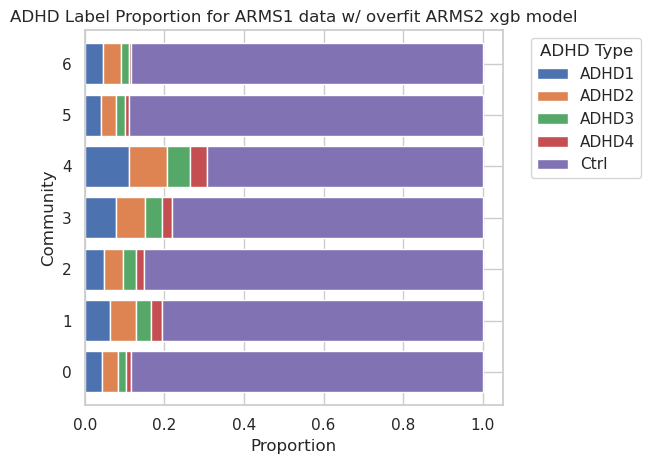

In [170]:
#plot the horizontal bar chart of the adhd label proportion data

#create the horizontal stacked bar chart
plt.figure(figsize=(12, 10))
ax = df_pivot.plot(kind='barh', stacked=True, width=0.8)

#customize the plot
plt.title('ADHD Label Proportion for ARMS1 data w/ overfit ARMS2 xgb model')
plt.xlabel('Proportion')
plt.ylabel('Community')

#remove the legend from its current position
plt.legend().remove()

#add a legend to the right of the plot
plt.legend(title='ADHD Type', bbox_to_anchor=(1.05, 1), loc='upper left')

#add percentage labels on the bars
#for c in ax.containers:
#    ax.bar_label(c, fmt='%.2f%%', label_type='center')

#adjust layout and display the plot
plt.tight_layout()
plt.savefig('./list_adhd_proportions_arms1data_arms2xgb.png', dpi=300, bbox_inches='tight')
plt.show()